<a href="https://colab.research.google.com/github/mauriciodev/braz_iono_series/blob/main/example_data_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2022 Mauricio Carvalho Mathias de Paulo and Danilo Souza

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [2]:
from datetime import datetime
import pandas as pd
import urllib
import os
from zipfile import ZipFile
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import re
import io
import urllib.request
import scipy
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Baixando o arquivo do github

In [ ]:
url="https://raw.githubusercontent.com/mauriciodev/braz_iono_series/main/iono_series.csv"
!wget --no-check-certificate $url

In [8]:
df=pd.read_csv("iono_series.csv")
df['date']=pd.to_datetime(df['date'])#.astype('datetime64[D]') #recognizes date column as date type
df

,Unnamed: 0,date,mean_I2L1,mean_I2L2,mean_I3L1,mean_I3L2,mean_VTEC,max_I2L1,max_I2L2,max_I3L1,...,maxA_I2L1,maxA_I2L2,maxA_I3L1,maxA_I3L2,minA_I2L1,minA_I2L2,minA_I3L1,minA_I3L2,f107cm,ap
0,0,2013-01-01,-0.001119,-0.002364,0.000360,0.000977,28.110519,0.007305,0.015441,0.002167,...,0.014304,0.030233,0.002167,0.005878,0.0,0.0,0.000003,0.000008,113.9,1.0
1,1,2013-01-02,-0.001118,-0.002362,0.000419,0.001136,30.918990,0.009081,0.019193,0.002758,...,0.013375,0.028269,0.002758,0.007480,0.0,0.0,0.000007,0.000020,115.0,4.0
2,2,2013-01-03,-0.001165,-0.002462,0.000430,0.001168,32.142493,0.008938,0.018891,0.002817,...,0.013253,0.028012,0.002817,0.007642,0.0,0.0,0.000004,0.000012,124.6,2.0
3,3,2013-01-04,-0.001172,-0.002476,0.000387,0.001049,30.376153,0.010350,0.021875,0.002988,...,0.013928,0.029438,0.002988,0.008104,0.0,0.0,0.000012,0.000032,138.4,2.0
4,4,2013-01-05,-0.001158,-0.002447,0.000422,0.001144,31.254700,0.008593,0.018163,0.002268,...,0.014508,0.030663,0.002268,0.006152,0.0,0.0,0.000008,0.000022,140.3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2551,2019-12-27,-0.000670,-0.001417,0.000091,0.000246,14.272649,0.004547,0.009610,0.000645,...,0.006514,0.013769,0.000645,0.001750,0.0,0.0,0.000002,0.000007,70.1,2.0
2552,2552,2019-12-28,-0.000615,-0.001299,0.000075,0.000202,12.787812,0.003576,0.007559,0.000406,...,0.006578,0.013904,0.000406,0.001101,0.0,0.0,0.000002,0.000004,69.8,1.0
2553,2553,2019-12-29,-0.000589,-0.001245,0.000081,0.000221,12.979281,0.004137,0.008743,0.000737,...,0.006528,0.013796,0.000737,0.002000,0.0,0.0,0.000001,0.000003,69.6,1.0
2554,2554,2019-12-30,-0.000569,-0.001203,0.000066,0.000179,12.319720,0.003811,0.008055,0.000521,...,0.006227,0.013161,0.000521,0.001412,0.0,0.0,0.000002,0.000007,68.6,2.0


# Limpando anomalias após o processamento

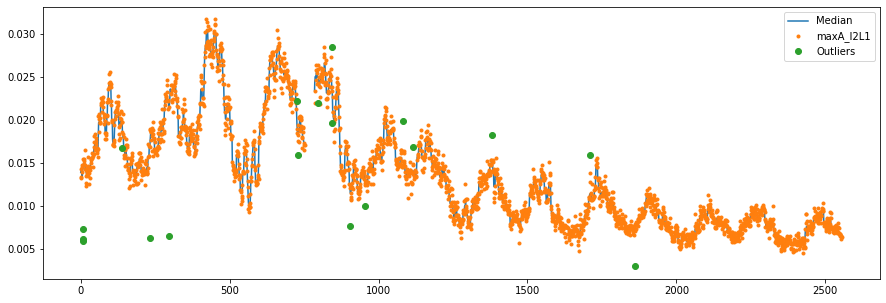

In [10]:
#|X-Xavg|<3*std
#column='max_VTEC'
column='maxA_I2L1'
nstd=3 #number of standard deviations above or bellow median
plt.figure(figsize=(15, 5))
s=df[column].rolling(9, center=True, min_periods=3).std()
median=df[column].rolling(9, center=True, min_periods=3).median(skipna=True)
plt.plot(median, label="Median")
#outliers=abs(df[column]-median)>nstd*s
outliers=abs(df[column]-median)>0.003
plt.plot(df[column], label=column, marker='.', linestyle="None")
plt.plot(df[outliers][column],marker='o',linestyle = 'None', label="Outliers")
plt.legend()

In [11]:
df[outliers]

,Unnamed: 0,date,mean_I2L1,mean_I2L2,mean_I3L1,mean_I3L2,mean_VTEC,max_I2L1,max_I2L2,max_I3L1,...,maxA_I2L1,maxA_I2L2,maxA_I3L1,maxA_I3L2,minA_I2L1,minA_I2L2,minA_I3L1,minA_I3L2,f107cm,ap
7,7,2013-01-08,-0.000812,-0.001717,0.000186,0.000504,23.518714,0.003556,0.007515,0.000533,...,0.007390,0.015619,0.000533,0.001446,0.000000,0.000000,0.000046,0.000126,150.5,4.0
8,8,2013-01-09,-0.000498,-0.001053,0.000389,0.001054,33.508119,0.006140,0.012978,0.001772,...,0.006140,0.012978,0.001772,0.004805,0.000000,0.000000,0.000089,0.000242,163.8,4.0
9,9,2013-01-10,-0.000700,-0.001480,0.000199,0.000541,24.247623,0.004132,0.008733,0.000600,...,0.005991,0.012662,0.000600,0.001628,0.000000,0.000000,0.000039,0.000106,168.2,3.0
138,138,2013-05-19,-0.001380,-0.002916,0.000301,0.000817,26.175199,0.005762,0.012178,0.002569,...,0.016760,0.035423,0.002569,0.006968,0.000000,0.000000,0.000005,0.000014,138.5,11.0
232,232,2013-08-21,-0.001420,-0.003002,0.000155,0.000420,20.201912,0.001496,0.003163,0.000538,...,0.006337,0.013393,0.000538,0.001459,0.000001,0.000001,0.000043,0.000115,133.4,18.0
296,296,2013-10-24,-0.000890,-0.001881,0.000706,0.001916,48.703656,0.006127,0.012950,0.002348,...,0.006566,0.013877,0.002348,0.006367,0.000000,0.000001,0.000255,0.000692,158.8,2.0
727,727,2014-12-29,-0.001908,-0.004033,0.000688,0.001866,41.004050,0.010109,0.021367,0.004038,...,0.022287,0.047106,0.004038,0.010953,0.000000,0.000000,0.000025,0.000067,127.1,21.0
731,731,2015-01-02,-0.001423,-0.003008,0.000473,0.001284,33.874125,0.009927,0.020981,0.002789,...,0.015969,0.033752,0.002789,0.007565,0.000000,0.000000,0.000012,0.000034,141.0,11.0
798,798,2015-03-10,-0.002010,-0.004249,0.001058,0.002870,51.013795,0.011930,0.025215,0.005293,...,0.022000,0.046498,0.005293,0.014358,0.000000,0.000000,0.000016,0.000042,119.2,4.0
842,842,2015-04-23,-0.002365,-0.004999,0.000852,0.002312,43.077512,0.010046,0.021233,0.006661,...,0.028473,0.060181,0.006661,0.018068,0.000000,0.000000,0.000005,0.000014,142.0,6.0


# Removendo da série

In [12]:
df[outliers] = np.nan

# Estatística descritiva

In [13]:
cols=["mean_I2L1","mean_I3L1","mean_I2L2","mean_I3L2", "mean_VTEC", "maxA_I2L1","maxA_I3L1","maxA_I2L2","maxA_I3L2" ]
df[cols].describe()

,mean_I2L1,mean_I3L1,mean_I2L2,mean_I3L2,mean_VTEC,maxA_I2L1,maxA_I3L1,maxA_I2L2,maxA_I3L2
count,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000
mean,-0.001165,0.000315,-0.002463,0.000854,23.599745,0.013407,0.002020,0.028337,0.005479
std,0.000559,0.000326,0.001181,0.000885,13.265545,0.006096,0.001764,0.012884,0.004785
min,-0.002930,0.000018,-0.006194,0.000048,5.855158,0.004604,0.000182,0.009730,0.000495
25%,-0.001528,0.000093,-0.003230,0.000253,13.997257,0.008283,0.000693,0.017506,0.001880
50%,-0.001062,0.000179,-0.002244,0.000487,19.659417,0.012274,0.001416,0.025942,0.003842
75%,-0.000715,0.000436,-0.001511,0.001182,31.568542,0.017251,0.002788,0.036461,0.007561
max,-0.000315,0.001641,-0.000665,0.004451,64.696015,0.031728,0.009017,0.067060,0.024458


# Gráficos individuais

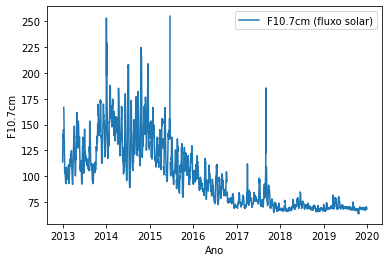

In [14]:
plt.plot(df['date'],df['f107cm'], label='F10.7cm (fluxo solar)')
plt.xlabel('Ano')
plt.ylabel('F10.7cm')
plt.legend()

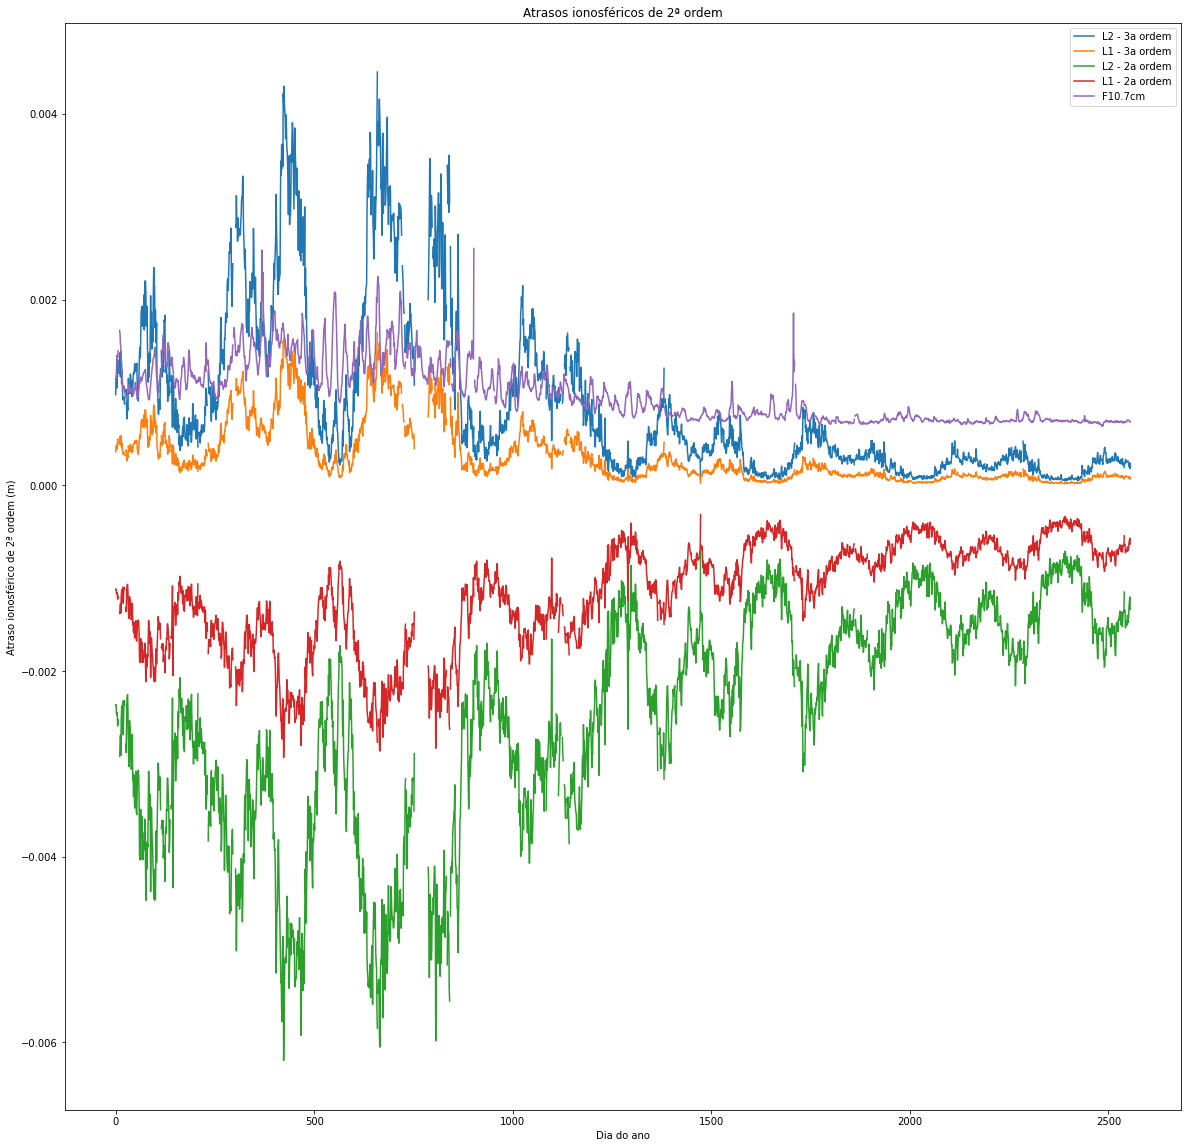

In [15]:
plt.figure(figsize=(20,20))
plt.plot(df[['mean_I3L2']], label="L2 - 3a ordem")
plt.plot(df[['mean_I3L1']], label="L1 - 3a ordem")
plt.plot(df[['mean_I2L2']], label="L2 - 2a ordem")
plt.plot(df[['mean_I2L1']], label="L1 - 2a ordem")
plt.plot(df[['f107cm']]/100000., label="F10.7cm")
plt.title('Atrasos ionosféricos de 2ª ordem')
plt.xlabel('Dia do ano')
plt.ylabel('Atraso ionosférico de 2ª ordem (m)')
plt.legend()
plt.show()

# Correlação

In [16]:
#Correlation using pandas
#df2=df.ffill()
df[cols+["f107cm"]].corr(method='pearson')

,mean_I2L1,mean_I3L1,mean_I2L2,mean_I3L2,mean_VTEC,maxA_I2L1,maxA_I3L1,maxA_I2L2,maxA_I3L2,f107cm
mean_I2L1,1.000000,-0.933962,1.000000,-0.933962,-0.966301,-0.981560,-0.956413,-0.981560,-0.956411,-0.811967
mean_I3L1,-0.933962,1.000000,-0.933962,1.000000,0.977347,0.934871,0.973472,0.934871,0.973472,0.777365
mean_I2L2,1.000000,-0.933962,1.000000,-0.933962,-0.966301,-0.981560,-0.956413,-0.981560,-0.956411,-0.811967
mean_I3L2,-0.933962,1.000000,-0.933962,1.000000,0.977347,0.934871,0.973472,0.934871,0.973472,0.777365
mean_VTEC,-0.966301,0.977347,-0.966301,0.977347,1.000000,0.954429,0.960521,0.954429,0.960520,0.791063
maxA_I2L1,-0.981560,0.934871,-0.981560,0.934871,0.954429,1.000000,0.970632,1.000000,0.970631,0.841864
maxA_I3L1,-0.956413,0.973472,-0.956413,0.973472,0.960521,0.970632,1.000000,0.970633,1.000000,0.813259
maxA_I2L2,-0.981560,0.934871,-0.981560,0.934871,0.954429,1.000000,0.970633,1.000000,0.970632,0.841864
maxA_I3L2,-0.956411,0.973472,-0.956411,0.973472,0.960520,0.970631,1.000000,0.970632,1.000000,0.813262
f107cm,-0.811967,0.777365,-0.811967,0.777365,0.791063,0.841864,0.813259,0.841864,0.813262,1.000000


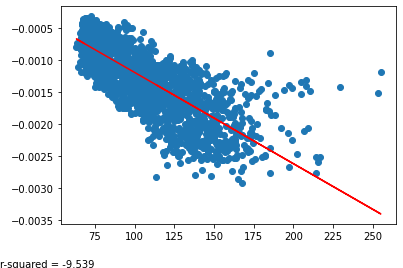

In [20]:
df2=df.dropna() #removing nan's
compareSeries=df2[['mean_I2L1']]
plt.scatter(df2[['f107cm']],compareSeries)
plt.annotate("r-squared = {:.3f}".format(r2_score(df2[['f107cm']], compareSeries)), (0, 1), xycoords='figure points')
y_test, y_predicted = df2[['f107cm']].to_numpy().reshape(-1,1), np.array(compareSeries).reshape(-1,1)
plt.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test), color="red")

# Gráficos das séries

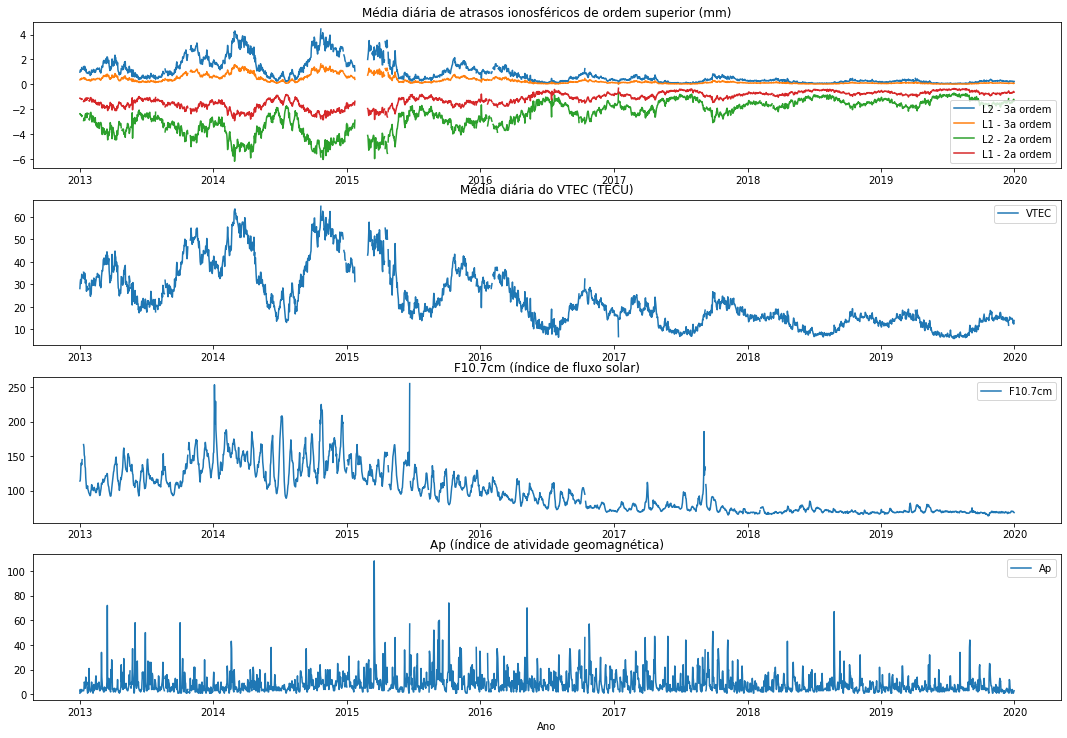

In [21]:
fig, axs = plt.subplots(4, figsize=(15, 10))
fig.tight_layout()
axs[0].set_title('Média diária de atrasos ionosféricos de ordem superior (mm)')
axs[0].plot(df['date'],df['mean_I3L2']*1000, label="L2 - 3a ordem")
axs[0].plot(df['date'],df['mean_I3L1']*1000, label="L1 - 3a ordem")
axs[0].plot(df['date'],df['mean_I2L2']*1000, label="L2 - 2a ordem")
axs[0].plot(df['date'],df['mean_I2L1']*1000, label="L1 - 2a ordem")
axs[0].legend()
axs[1].set_title('Média diária do VTEC (TECU)')
axs[1].plot(df['date'],df['mean_VTEC'], label="VTEC")
axs[1].legend()
axs[2].set_title('F10.7cm (índice de fluxo solar)')
axs[2].plot(df['date'],df['f107cm'], label="F10.7cm")
axs[2].legend()
axs[3].set_title('Ap (índice de atividade geomagnética)')
axs[3].plot(df['date'],df['ap'], label="Ap")
axs[3].legend()
plt.xlabel('Ano')
plt.show()

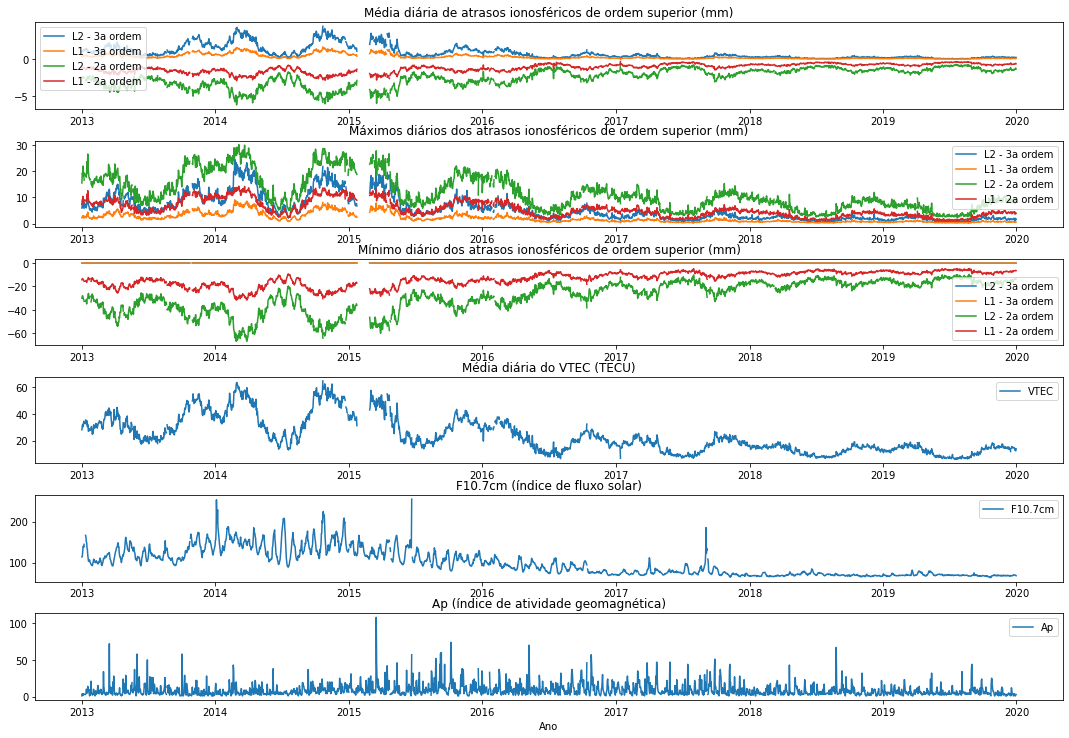

In [22]:

fig, axs = plt.subplots(6, figsize=(15, 10))
fig.tight_layout()
axs[0].set_title('Média diária de atrasos ionosféricos de ordem superior (mm)')
axs[0].plot(df['date'],df['mean_I3L2']*1000, label="L2 - 3a ordem")
axs[0].plot(df['date'],df['mean_I3L1']*1000, label="L1 - 3a ordem")
axs[0].plot(df['date'],df['mean_I2L2']*1000, label="L2 - 2a ordem")
axs[0].plot(df['date'],df['mean_I2L1']*1000, label="L1 - 2a ordem")
axs[0].legend()
axs[1].set_title('Máximos diários dos atrasos ionosféricos de ordem superior (mm)')
axs[1].plot(df['date'],df['max_I3L2']*1000, label="L2 - 3a ordem")
axs[1].plot(df['date'],df['max_I3L1']*1000, label="L1 - 3a ordem")
axs[1].plot(df['date'],df['max_I2L2']*1000, label="L2 - 2a ordem")
axs[1].plot(df['date'],df['max_I2L1']*1000, label="L1 - 2a ordem")
axs[1].legend()
axs[2].set_title('Mínimo diário dos atrasos ionosféricos de ordem superior (mm)')
axs[2].plot(df['date'],df['min_I3L2']*1000, label="L2 - 3a ordem")
axs[2].plot(df['date'],df['min_I3L1']*1000, label="L1 - 3a ordem")
axs[2].plot(df['date'],df['min_I2L2']*1000, label="L2 - 2a ordem")
axs[2].plot(df['date'],df['min_I2L1']*1000, label="L1 - 2a ordem")
axs[2].legend()
axs[3].set_title('Média diária do VTEC (TECU)')
axs[3].plot(df['date'],df['mean_VTEC'], label="VTEC")
axs[3].legend()
axs[4].set_title('F10.7cm (índice de fluxo solar)')
axs[4].plot(df['date'],df['f107cm'], label="F10.7cm")
axs[4].legend()
axs[5].set_title('Ap (índice de atividade geomagnética)')
axs[5].plot(df['date'],df['ap'], label="Ap")
axs[5].legend()
plt.xlabel('Ano')
plt.show()


## Gráfico com valores absolutos


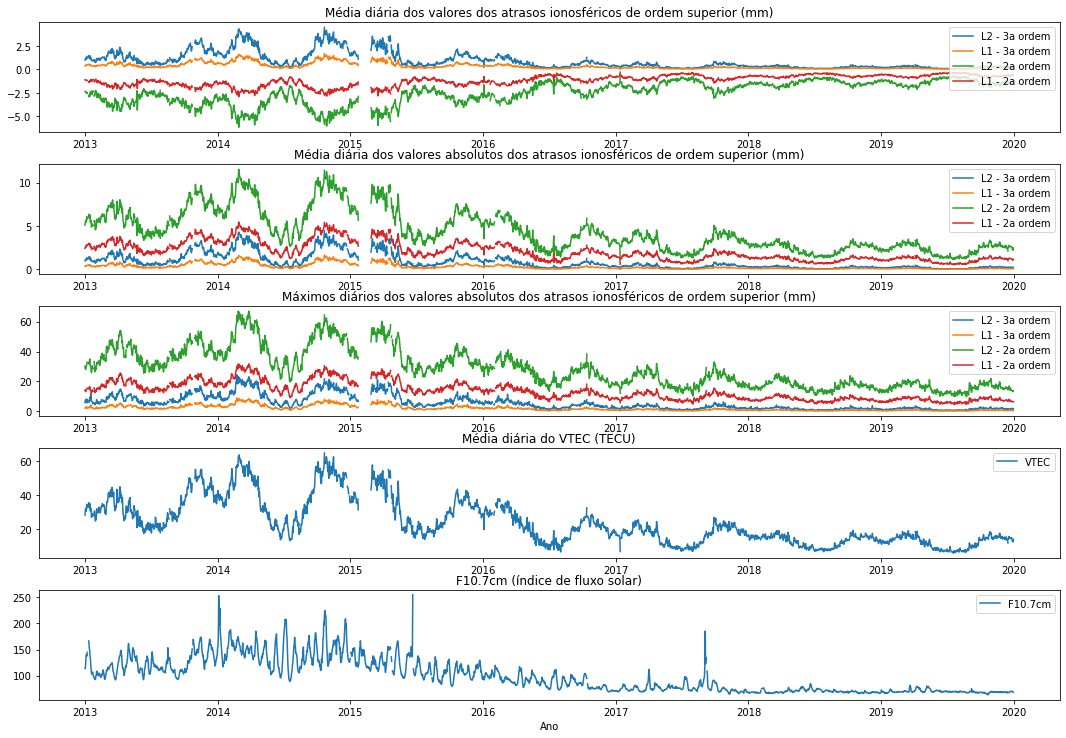

In [24]:
fig, axs = plt.subplots(5, figsize=(15, 10))
fig.tight_layout()
i=0
axs[i].set_title('Média diária dos valores dos atrasos ionosféricos de ordem superior (mm)')
axs[i].plot(df['date'],df['mean_I3L2']*1000, label="L2 - 3a ordem")
axs[i].plot(df['date'],df['mean_I3L1']*1000, label="L1 - 3a ordem")
axs[i].plot(df['date'],df['mean_I2L2']*1000, label="L2 - 2a ordem")
axs[i].plot(df['date'],df['mean_I2L1']*1000, label="L1 - 2a ordem")
axs[i].legend(loc=1)
i+=1
axs[i].set_title('Média diária dos valores absolutos dos atrasos ionosféricos de ordem superior (mm)')
axs[i].plot(df['date'],df['meanA_I3L2']*1000, label="L2 - 3a ordem")
axs[i].plot(df['date'],df['meanA_I3L1']*1000, label="L1 - 3a ordem")
axs[i].plot(df['date'],df['meanA_I2L2']*1000, label="L2 - 2a ordem")
axs[i].plot(df['date'],df['meanA_I2L1']*1000, label="L1 - 2a ordem")
axs[i].legend(loc=1)
i+=1
axs[i].set_title('Máximos diários dos valores absolutos dos atrasos ionosféricos de ordem superior (mm)')
axs[i].plot(df['date'],df['maxA_I3L2']*1000, label="L2 - 3a ordem")
axs[i].plot(df['date'],df['maxA_I3L1']*1000, label="L1 - 3a ordem")
axs[i].plot(df['date'],df['maxA_I2L2']*1000, label="L2 - 2a ordem")
axs[i].plot(df['date'],df['maxA_I2L1']*1000, label="L1 - 2a ordem")
axs[i].legend(loc=1)
i+=1
"""axs[i].set_title('Mínimos diários dos valores absolutos dos atrasos ionosféricos de ordem superior (mm)')
axs[i].plot(df['date'],df['minA_I3L2']*1000, label="L2 - 3a ordem")
axs[i].plot(df['date'],df['minA_I3L1']*1000, label="L1 - 3a ordem")
axs[i].plot(df['date'],df['minA_I2L2']*1000, label="L2 - 2a ordem")
axs[i].plot(df['date'],df['minA_I2L1']*1000, label="L1 - 2a ordem")
axs[i].legend(loc=1)
i+=1"""
axs[i].set_title('Média diária do VTEC (TECU)')
axs[i].plot(df['date'],df['mean_VTEC'], label="VTEC")
axs[i].legend(loc=1)
i+=1
axs[i].set_title('F10.7cm (índice de fluxo solar)')
axs[i].plot(df['date'],df['f107cm'], label="F10.7cm")
axs[i].legend(loc=1)
"""i+=1
axs[i].set_title('Ap (índice de atividade geomagnética)')
axs[i].plot(df['date'],df['ap'], label="Ap")
axs[i].legend(loc=1)"""
plt.xlabel('Ano')
plt.savefig("absValues.svg")
plt.show()